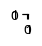

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150

sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.conv_models import CNNVAE, TwoStageCNNVAECLF
from src.metrics import reconstruction_accuracy, compute_cosine_distance
from src.cluster_utils import *
from src.networkx_utils import *

# Get patient reconstruction accuracies

In [11]:
from joblib import Parallel, delayed
from functools import partial
MAXLENS={'A1':7, 'A2':8, 'A3':22, 'B1':6, 'B2':7, 'B3':23}
def split_seq(seq, max_lens={'A1':7, 'A2':8, 'A3':22, 'B1':6, 'B2':7, 'B3':23}):
    rec_seq = []
    i=0
    for name,length in max_lens.items():
        if length==0:
            continue
        rec_seq.append(seq[i:i+length].rstrip('X'))
        i+=length
    return rec_seq

def get_all_split(df, max_lens={'A1':7, 'A2':8, 'A3':22, 'B1':6, 'B2':7, 'B3':23}):
    df=df.copy()
    df.drop(columns=[x for x in df.columns if x.startswith('z_')], inplace=True)
    df[list(f'{k}_true_rec' for k,v in max_lens.items() if v!=0)] = pd.DataFrame(df['true_reconstructed'].apply(split_seq,max_lens=max_lens).tolist(), index=df.index)
    df[list(f'{k}_hat_rec' for k,v in max_lens.items() if v!=0)] = pd.DataFrame(df['hat_reconstructed'].apply(split_seq,max_lens=max_lens).tolist(), index=df.index)
    return df
    
def get_cdr_acc(true, rec):
    if len(true)==len(rec):
        return np.mean([x==y for x,y in zip(true,rec)])
    elif len(true)>len(rec):
        return np.mean([x==y for x,y in zip(true, rec+(len(true)-len(rec))*'X')])
    elif len(true)<len(rec):
        return np.mean([x==y for x,y in zip(true, rec+(len(rec)-len(true))*'X')])
    else:
        return 0
      

In [12]:
def glob_path(path, pattern):
    pt = glob.glob(f'{path}*{pattern}*.pt')[0]
    js = glob.glob(f'{path}*JSON_kwargs*.json')[0]
    return pt, js

  
def get_per_seq_acc(df, max_lens={'A1':7, 'A2':8, 'A3':22, 'B1':6, 'B2':7, 'B3':23}):
    df = df.copy()
    df = get_all_split(df, max_lens)
    true_cols=list(f'{k}_true_rec' for k,v in max_lens.items() if v!=0)
    rec_cols=list(f'{k}_hat_rec' for k,v in max_lens.items() if v!=0)
    for true, rec in zip(true_cols, rec_cols):
        chain = true.rstrip('_true_rec')
        df[f'acc_{chain}'] =  df.apply(lambda x: get_cdr_acc(x[true], x[rec]), axis=1)
    return df

In [13]:
garner = pd.read_csv('../data/OTS/garner_merged/garner_merged_41_42_43.csv')
francis = pd.concat([pd.read_csv(x) for x in glob.glob(f'../data/OTS/francis_covid_042/*')])

In [14]:
os_notrp_path = '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_KFold_0_240730_1501_6omni/'
os_cstrp_path = '../output/240618_NestedKCV_CNNVAE/Nested_CNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1607_ER8wJ/'
ts_notrp_path = '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_NOTRIPLET_ld128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_N1jMC/'
ts_cstrp_path = '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_BLOSUM_PEP_KFold_0_240910_1436_jyGpd/'
os_notrp = load_model_full(*glob_path(os_notrp_path, 'best'))
ts_notrp = load_model_full(*glob_path(ts_notrp_path, '4500'))
os_cstrp = load_model_full(*glob_path(os_cstrp_path, 'best'))
ts_cstrp = load_model_full(*glob_path(ts_cstrp_path, '4500'))

<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
No GPUs available. Using CPU.
Reloading best model:
Best epoch: 19904
total: 0.3804485993018143
reconstruction: 0.3688316931078958
kld: 0.011616906193918503
triplet: 0.0
seq_accuracy: 0.9929980039596558
pos_accuracy: 0.9998289346694946
<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
No GPUs available. Using CPU.
Reloading best model:
epoch: 4500
total: 0.7775099739190969
reconstruction: 0.24511546373418122
kld: 0.0
triplet: 0.0
BCE: 0.5323945055735589
seq_accuracy: 0.9910694360733032
pos_accuracy: 0.9997903108596802
auc: 0.7436
auc_01: 0.59057
auc_01_real: 0.22208
precision: 0.39935
recall: 0.43906
accuracy: 0.79582
AP: 0.35665
<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()
No GPUs available. Using CPU.
Reloading best model:
Best epoch: 19934
total: 0.07886607476881971
reconstruction: 0.05939108139774983
kld: 0.003005831211369365
triplet: 0.01646916461991662
seq_accuracy: 

In [19]:
garner_os_notrp = get_latent_df(os_notrp, garner)
francis_os_notrp = get_latent_df(os_notrp, francis)
garner_ts_notrp = get_latent_df(ts_notrp, garner)
francis_ts_notrp = get_latent_df(ts_notrp, francis)
garner_os_cstrp = get_latent_df(os_cstrp, garner)
francis_os_cstrp = get_latent_df(os_cstrp, francis)
garner_ts_cstrp = get_latent_df(ts_cstrp, garner)
francis_ts_cstrp = get_latent_df(ts_cstrp, francis)

In [28]:
garner_os_notrp = garner_os_notrp.drop(columns=[x for x in garner_os_notrp.columns if x.startswith('z_')])
francis_os_notrp = francis_os_notrp.drop(columns=[x for x in francis_os_notrp.columns if x.startswith('z_')])
garner_ts_notrp = garner_ts_notrp.drop(columns=[x for x in garner_ts_notrp.columns if x.startswith('z_')])
francis_ts_notrp = francis_ts_notrp.drop(columns=[x for x in francis_ts_notrp.columns if x.startswith('z_')])
garner_os_cstrp = garner_os_cstrp.drop(columns=[x for x in garner_os_cstrp.columns if x.startswith('z_')])
francis_os_cstrp = francis_os_cstrp.drop(columns=[x for x in francis_os_cstrp.columns if x.startswith('z_')])
garner_ts_cstrp = garner_ts_cstrp.drop(columns=[x for x in garner_ts_cstrp.columns if x.startswith('z_')])
francis_ts_cstrp = francis_ts_cstrp.drop(columns=[x for x in francis_ts_cstrp.columns if x.startswith('z_')])

In [38]:
from src.utils import flatten_level_columns
COLS= ['partition', 'peptide', 'A1','A2','A3','B1','B2','B3', 
       'A1_hat_rec','A2_hat_rec','A3_hat_rec', 'B1_hat_rec', 'B2_hat_rec', 'B3_hat_rec', 
       'acc_A1', 'acc_A2', 'acc_A3', 'acc_B1', 'acc_B2', 'acc_B3', 'seq_acc']
garner_total = pd.concat([get_per_seq_acc(garner_os_notrp).assign(Dataset='garner', Model='os_notrp'), 
                          get_per_seq_acc(garner_ts_notrp).assign(Dataset='garner', Model='ts_notrp'), 
                          get_per_seq_acc(garner_os_cstrp).assign(Dataset='garner', Model='os_cstrp'), 
                          get_per_seq_acc(garner_ts_cstrp).assign(Dataset='garner', Model='ts_cstrp')])
francis_total = pd.concat([get_per_seq_acc(francis_os_notrp).assign(Dataset='francis', Model='os_notrp'), 
                           get_per_seq_acc(francis_ts_notrp).assign(Dataset='francis', Model='ts_notrp'), 
                           get_per_seq_acc(francis_os_cstrp).assign(Dataset='francis', Model='os_cstrp'), 
                           get_per_seq_acc(francis_ts_cstrp).assign(Dataset='francis', Model='ts_cstrp')])
total = pd.concat([garner_total, francis_total])[[x for x in COLS if x in garner_total.columns]+['Model','Dataset']]
del garner_total, francis_total
total_gb = total.groupby(['Model', 'Dataset'])[[x for x in total.columns if "acc" in x]].describe()
drop_cols = [x for x in total_gb.describe().columns if x[1] in ['count', '25%', '50%', '75%']]
total_gb = flatten_level_columns(total_gb.drop(columns=drop_cols))
total_gb = total_gb.round(5).T
total_gb

Model        os_cstrp          os_notrp          ts_cstrp          ts_notrp  \
Dataset       francis   garner  francis   garner  francis   garner  francis   
acc_a1_mean   0.99291  0.99832  0.97843  0.99527  0.98059  0.99527  0.96497   
acc_a1_std    0.04120  0.02166  0.07368  0.03556  0.06652  0.03520  0.12037   
acc_a1_min    0.16667  0.16667  0.33333  0.33333  0.28571  0.16667  0.33333   
acc_a1_max    1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000   
acc_a2_mean   0.98287  0.99328  0.98435  0.99306  0.98302  0.99365  0.97986   
acc_a2_std    0.06064  0.03919  0.05169  0.03942  0.05880  0.03674  0.06645   
acc_a2_min    0.00000  0.00000  0.00000  0.16667  0.00000  0.00000  0.14286   
acc_a2_max    1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000   
acc_a3_mean   0.98768  0.99548  0.98949  0.99567  0.98496  0.99465  0.98249   
acc_a3_std    0.03957  0.02374  0.04028  0.02412  0.04125  0.02508  0.04985   
acc_a3_min    0.47368  0.66667  0.50000  0.63158  0.50000  0.64706  0.40000   
acc_a3_max    1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000   
acc_b1_mean   0.99819  0.99670  0.99935  0.99775  0.99815  0.99746  0.99933   
acc_b1_std    0.02291  0.02830  0.01237  0.02646  0.02928  0.02851  0.01322   
acc_b1_min    0.60000  0.40000  0.60000  0.40000  0.40000  0.20000  0.40000   
acc_b1_max    1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000   
acc_b2_mean   0.99816  0.99805  0.99891  0.99770  0.99720  0.99727  0.99896   
acc_b2_std    0.02354  0.02332  0.01777  0.02830  0.02370  0.02743  0.01674   
acc_b2_min    0.16667  0.25000  0.16667  0.00000  0.33333  0.16667  0.33333   
acc_b2_max    1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000   
acc_b3_mean   0.99225  0.99520  0.98950  0.99323  0.99289  0.99479  0.98397   
acc_b3_std    0.03675  0.02737  0.04456  0.03445  0.03343  0.02742  0.05103   
acc_b3_min    0.38095  0.42857  0.40000  0.38095  0.47619  0.47619  0.25000   
acc_b3_max    1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000   
seq_acc_mean  0.99094  0.99574  0.98898  0.99477  0.98887  0.99508  0.98345   
seq_acc_std   0.02134  0.01450  0.02426  0.01702  0.02456  0.01601  0.03183   
seq_acc_min   0.70000  0.75439  0.73016  0.75926  0.72000  0.79630  0.71429   
seq_acc_max   1.00000  1.00000  1.00000  1.00000  1.00000  1.00000  1.00000   

Model                  
Dataset        garner  
acc_a1_mean   0.99224  
acc_a1_std    0.05875  
acc_a1_min    0.33333  
acc_a1_max    1.00000  
acc_a2_mean   0.99172  
acc_a2_std    0.04551  
acc_a2_min    0.25000  
acc_a2_max    1.00000  
acc_a3_mean   0.99277  
acc_a3_std    0.03107  
acc_a3_min    0.47059  
acc_a3_max    1.00000  
acc_b1_mean   0.99686  
acc_b1_std    0.02887  
acc_b1_min    0.40000  
acc_b1_max    1.00000  
acc_b2_mean   0.99823  
acc_b2_std    0.02499  
acc_b2_min    0.00000  
acc_b2_max    1.00000  
acc_b3_mean   0.98952  
acc_b3_std    0.04000  
acc_b3_min    0.40000  
acc_b3_max    1.00000  
seq_acc_mean  0.99248  
seq_acc_std   0.02075  
seq_acc_min   0.75472  
seq_acc_max   1.00000

In [39]:
total_gb.to_csv('../../../writing/VAE_TCR_DRAFT/tables/240919_patient_reconstruction_accuracies.csv')

# Get Kmeansret-pur graph

## inits

In [2]:
from sklearn.neighbors import KNeighborsClassifier
# dataset = pd.read_csv(X)~
# def knn_retpur(

In [45]:
data=pd.read_csv('../output/240411_ClusteringTests/dist_matrices/2404XX_OUTPUT_tbcralign_distmatrix_26peps_labeled.csv')
data.set_index('q_index', inplace=True)

In [56]:
from sklearn.preprocessing import LabelEncoder
sample = data.sample(100, random_state=1)
sample = sample[[str(x) for x in sample.index]+['binder','peptide','original_index']]
sample_array = sample.iloc[:len(sample), :len(sample)]
labels = sample['peptide'].values
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
knn = KNeighborsClassifier(5, metric='precomputed', n_jobs=-1)
knn.fit(sample_array, encoded_labels)

KNeighborsClassifier(metric='precomputed', n_jobs=-1)

In [3]:
# KMeans
from sklearn.cluster import KMeans
easy5peps = ['GILGFVFTL', 'ELAGIGILTV', 'RAKFKQLL', 'YLQPRTFLL', 'CINGVCWTV'] 
sample = pd.read_csv('../data/filtered/240326_nettcr_paired_NOswaps.csv').query('partition==0 and peptide in @easy5peps').sample(frac=0.5)
latent = get_latent_df(os_cstrp, sample)
features = latent[[z for z in latent.columns if z.startswith('z_')]].values
labels = latent['peptide'].values
label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(labels)
km = KMeans(n_clusters=len(sample)-1)
km.fit(features)
predicted_labels = km.predict(features)

NameError: name 'os_cstrp' is not defined

In [4]:
from sklearn.metrics import silhouette_samples, silhouette_score
def get_purity_mixity(cluster_label: int,
                                true_labels: list,
                                pred_labels: list,
                                label_encoder):
    """
        For a given cluster label (int) returned by clustering.labels_,
        Return the purity, mixity, coherence, cluster_size, and scale (==cluster_size/total_size)
        scale should be used to get a weighted average metric at the end
    """
    indices = np.where(pred_labels == cluster_label)[0]
    cluster_size = len(indices)
    if cluster_size <= 1:
        # return np.nan, np.nan, np.nan, 1, 1/len(true_labels)
        return {'purity': np.nan, 'cluster_size': 1}

    # Query the subset of the true labels belonging to this cluster using indices
    # Convert to int label encodings in order to use np.bincount to get purity and mixity

    subset = true_labels[indices]
    encoded_subset = label_encoder.transform(subset)
    counts = {i: k for i, k in enumerate(np.bincount(encoded_subset)) if k > 0}
    majority_label = label_encoder.inverse_transform([sorted(counts.items(), key=lambda x: x[1], reverse=True)[0][0]])[
        0]
    purity = get_purity(counts)
    # mixity = get_mixity(counts)
    # index the distance matrix and return the mean distance within this cluster (i.e. coherence)

    # return purity, mixity, coherence, cluster_size, cluster_size / len(true_labels)
    return {'purity': purity, 'cluster_size': cluster_size, 'majority_label': majority_label}



def get_kmeans_metrics(t, features, c, true_labels, encoded_labels, label_encoder, return_df=False):
    n_cluster = np.sum((np.bincount(c.labels_) > 1))
    n_singletons = (np.bincount(c.labels_) == 1).sum()
    try:
        s_score = silhouette_score(features, c.labels_, metric='cosine')
    except:
        s_score = np.nan
    try:
        c_score = ch_score(features, c.labels_)
    except:
        c_score = np.nan
    try:
        d_score = db_score(features, c.labels_)
    except:
        d_score = np.nan
    try:
        ari_score = adjusted_rand_score(encoded_labels, c.labels_)
    except:
        ari_score = np.nan
    
    df_out = pd.concat(
        [pd.DataFrame(get_purity_mixity(label_i, true_labels, c.labels_, label_encoder), index=[0])
         for label_i in set(c.labels_)]).reset_index(drop=True).reset_index().rename(columns={'index': 'pred_label'})
    nc_07 = len(df_out.query('purity>=0.7'))
    if return_df:
        return {'threshold': t,
                'n_cluster': n_cluster, 'n_singletons': n_singletons,
                'n_cluster_over_70p': nc_07,
                'mean_purity': df_out['purity'].mean(),
                'min_purity': df_out['purity'].min(),
                'max_purity': df_out['purity'].max(),
                'mean_cluster_size': df_out['cluster_size'].mean(),
                'min_cluster_size': df_out['cluster_size'].min(),
                'max_cluster_size': df_out['cluster_size'].max(),
                'silhouette': s_score,
                'ch_index': c_score, 'db_index': d_score, 'ARI': ari_score}, df_out
    else:
        return {'threshold': t,
                'n_cluster': n_cluster, 'n_singletons': n_singletons,
                'n_cluster_over_70p': nc_07,
                'mean_purity': df_out['purity'].mean(),
                'min_purity': df_out['purity'].min(),
                'max_purity': df_out['purity'].max(),
                'mean_cluster_size': df_out['cluster_size'].mean(),
                'min_cluster_size': df_out['cluster_size'].min(),
                'max_cluster_size': df_out['cluster_size'].max(),
                'silhouette': s_score,
                'ch_index': c_score, 'db_index': d_score, 'ARI': ari_score}
        

In [7]:
def kmeans_all_thresholds(features, labels, encoded_labels, label_encoder, n_jobs=1):
    # Getting clustering at all thresholds, from 2 clusters to every clusters being duplets
    limits = np.arange(2, len(features))
    if n_jobs > 1:
        wrapper = partial(kmeans_single_threshold, features=features, labels=labels,
                          encoded_labels=encoded_labels, label_encoder=label_encoder)
        results = Parallel(n_jobs=n_jobs)(delayed(wrapper)(k=k) for k in tqdm(limits))
    else:
        results = []
        for t in tqdm(limits):
            results.append(kmeans_single_threshold(features, labels, encoded_labels, label_encoder, t))
    results = pd.DataFrame(results).sort_values('threshold')
    results['retention'] = (len(labels) - results['n_singletons']) / len(labels)
    return results

def kmeans_single_threshold(features, labels, encoded_labels, label_encoder, k,
                             return_df_and_c=False):
    if k>= len(features)//2:
        max_iter=75
    c = KMeans(n_clusters=k, max_iter=max_iter)
    c.fit(features)
    if return_df_and_c:
        return *get_kmeans_metrics(threshold, features, c, labels, encoded_labels, label_encoder,
                                return_df=return_df_and_c), c
    else:
        return get_kmeans_metrics(k, features, c, labels, encoded_labels, label_encoder)

# kmeans_single_threshold(features, labels, encoded_labels, label_encoder, k=200)

In [8]:
def get_purity_mixity(cluster_label: int,
                                true_labels: list,
                                pred_labels: list,
                                label_encoder):
    """
        For a given cluster label (int) returned by clustering.labels_,
        Return the purity, mixity, coherence, cluster_size, and scale (==cluster_size/total_size)
        scale should be used to get a weighted average metric at the end
    """
    indices = np.where(pred_labels == cluster_label)[0]
    cluster_size = len(indices)
    if cluster_size <= 1:
        # return np.nan, np.nan, np.nan, 1, 1/len(true_labels)
        return {'purity': np.nan, 'coherence': np.nan, 'cluster_size': 1}

    # Query the subset of the true labels belonging to this cluster using indices
    # Convert to int label encodings in order to use np.bincount to get purity and mixity

    subset = true_labels[indices]
    encoded_subset = label_encoder.transform(subset)
    counts = {i: k for i, k in enumerate(np.bincount(encoded_subset)) if k > 0}
    majority_label = label_encoder.inverse_transform([sorted(counts.items(), key=lambda x: x[1], reverse=True)[0][0]])[
        0]
    purity = get_purity(counts)
    # mixity = get_mixity(counts)
    # index the distance matrix and return the mean distance within this cluster (i.e. coherence)

    # return purity, mixity, coherence, cluster_size, cluster_size / len(true_labels)
    return {'purity': purity, 'cluster_size': cluster_size, 'majority_label': majority_label}

In [254]:
out = kmeans_all_thresholds(features, labels, encoded_labels, label_encoder, n_jobs=8)

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

In [263]:
pd.read_csv('../output/240618_NestedKCV_CNNVAE/clustering/Nested_CNNVAE_latent_128_kld_1e-2_ExpData_ExpData17peps_KFold_v0_t1_240620_1257_ER8wJ/Nested_CNNVAE_latent_128_kld_1e-2_ExpData_ExpData17peps_KFold_v0_t1_240620_1257_ER8wJ_test_results.csv')


,Unnamed: 0,threshold,n_cluster,n_singletons,n_cluster_over_70p,mean_purity,min_purity,max_purity,mean_coherence,min_coherence,max_coherence,mean_cluster_size,min_cluster_size,max_cluster_size,silhouette,ch_index,db_index,ARI,retention,input_type
0,0,0.00557,0,1470,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000,0.000000,TBCRalign
1,1,0.00623,1,1468,1,1.000000,1.000000,1.000000,0.005576,0.005576,0.005576,2.0,2.0,2.0,0.0,0.508803,10.448633,0.00002,0.001361,TBCRalign
2,2,0.00689,1,1468,1,1.000000,1.000000,1.000000,0.005576,0.005576,0.005576,2.0,2.0,2.0,0.0,0.508803,10.448633,0.00002,0.001361,TBCRalign
3,3,0.00755,1,1468,1,1.000000,1.000000,1.000000,0.005576,0.005576,0.005576,2.0,2.0,2.0,0.0,0.508803,10.448633,0.00002,0.001361,TBCRalign
4,4,0.00821,1,1468,1,1.000000,1.000000,1.000000,0.005576,0.005576,0.005576,2.0,2.0,2.0,0.0,0.508803,10.448633,0.00002,0.001361,TBCRalign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,495,0.62987,2,0,0,0.197482,0.159670,0.235294,0.359444,0.332498,0.386389,735.0,17.0,1453.0,0.0,0.007104,84.499144,NaN,1.000000,agg_epoch_12000
9996,496,0.63113,2,0,0,0.197482,0.159670,0.235294,0.359444,0.332498,0.386389,735.0,17.0,1453.0,0.0,0.007104,84.499144,NaN,1.000000,agg_epoch_12000
9997,497,0.63238,2,0,0,0.197482,0.159670,0.235294,0.359444,0.332498,0.386389,735.0,17.0,1453.0,0.0,0.007104,84.499144,NaN,1.000000,agg_epoch_12000
9998,498,0.63364,2,0,0,0.197482,0.159670,0.235294,0.359444,0.332498,0.386389,735.0,17.0,1453.0,0.0,0.007104,84.499144,NaN,1.000000,agg_epoch_12000


## ExpData Top17

In [17]:
def kmeans_pipeline(model, df, model_name, dataset_name, partition, n_jobs=10):
    latent = get_latent_df(model, df)
    features = latent[[z for z in latent.columns if z.startswith('z_')]]
    labels = latent['peptide'].values
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)
    out = kmeans_all_thresholds(features, labels, encoded_labels, label_encoder, n_jobs)
    out['input_type']=model_name
    out['dataset']=dataset_name
    out['partition'] = partition
    return out

In [18]:
top17 = pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv')

df = top17.copy()
train = df.query('partition!=0 and partition!=1')
valid = df.query('partition==0')
test = df.query('partition==1')

results = []
for model, name in zip([os_notrp, ts_notrp, os_cstrp, ts_cstrp], ['os_notrp', 'ts_notrp', 'os_cstrp', 'ts_cstrp']):
    # results.append(kmeans_pipeline(model, train, name, 'top17', 'train'))
    results.append(kmeans_pipeline(model, test, name, 'top17', 'test'))
    results.append(kmeans_pipeline(model, valid, name, 'top17', 'valid'))
    break

  0%|          | 0/1468 [00:00<?, ?it/s]

  0%|          | 0/1469 [00:00<?, ?it/s]

## ExpData Top78

In [267]:
top78 = pd.read_csv('../data/filtered/240507_nettcr_exp_pruned_noswap_78peps.csv')
df = top78.copy()
train = df.query('partition!=0 and partition!=1')
valid = df.query('partition==0')
test = df.query('partition==1')

for model, name in zip([os_notrp, ts_notrp, os_cstrp, ts_cstrp], ['os_notrp', 'ts_notrp', 'os_cstrp', 'ts_cstrp']):
    results.append(kmeans_pipeline(model, train, name, 'top17', 'train'))
    results.append(kmeans_pipeline(model, test, name, 'top17', 'test'))
    results.append(kmeans_pipeline(model, valid, name, 'top17', 'valid'))

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

  0%|          | 0/306 [00:00<?, ?it/s]

/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/riwa/opt/anaconda3/envs/pynn/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

## results

In [19]:
kmeans_results = pd.concat(results)
# kmeans_results.to_csv('../output/240618_NestedKCV_CNNVAE/clustering/kmeans_results_4vaes.csv')

In [20]:
kmeans_results['clustering'] = 'KMeans'

In [21]:
model_names = ['os_notrp', 'ts_cstrp', 'os_cstrp', 'ts_notrp']
ntr = ['checkpoint_best', 'epoch_4500', 'checkpoint_best', 'epoch_4500']
test_files = [x for x in glob.glob('../output/240618_NestedKCV_CNNVAE/clustering/*17p*/*test*.csv') if '6omni' in x or 'jyGpd' in x or 'N1jMC' in x or 'ER8wJ' in x]
valid_files = [x for x in glob.glob('../output/240618_NestedKCV_CNNVAE/clustering/*17p*/*valid*.csv') if '6omni' in x or 'jyGpd' in x or 'N1jMC' in x or 'ER8wJ' in x]
train_files = [x for x in glob.glob('../output/240618_NestedKCV_CNNVAE/clustering/*17p*/*train*.csv') if '6omni' in x or 'jyGpd' in x or 'N1jMC' in x or 'ER8wJ' in x]
train_res = pd.concat([pd.read_csv(x).query('input_type==@z').assign(input_type=m) for x,m,z in zip(train_files, model_names, ntr)]).assign(db='top17', partition='train', clustering='Agglo')
valid_res = pd.concat([pd.read_csv(x).query('input_type==@z').assign(input_type=m) for x,m,z in zip(valid_files, model_names, ntr)]).assign(db='top17', partition='valid', clustering='Agglo')
test_res = pd.concat([pd.read_csv(x).query('input_type==@z').assign(input_type=m) for x,m,z in zip(test_files, model_names, ntr)]).assign(db='top17', partition='test', clustering='Agglo')

train_baseline = pd.read_csv(train_files[0]).query('not input_type.str.contains("0") and not input_type.str.contains("check")').assign(partition='train', db='top17', clustering='Agglo')
valid_baseline = pd.read_csv(valid_files[0]).query('not input_type.str.contains("0") and not input_type.str.contains("check")').assign(partition='valid', db='top17', clustering='Agglo')
test_baseline = pd.read_csv(test_files[0]).query('not input_type.str.contains("0") and not input_type.str.contains("check")').assign(partition='test', db='top17', clustering='Agglo')

In [22]:
concat_res = pd.concat([kmeans_results.assign(clustering='KMeans'), 
                        train_res, valid_res, test_res, 
                        train_baseline, valid_baseline, test_baseline])
concat_res['hue'] = concat_res.apply(lambda x: x['clustering']+'_'+x['input_type'], axis=1)
concat_res.drop(columns=[x for x in concat_res.columns if 'coherence' in x or 'Unn' in x], inplace=True)
# concat_res.to_csv('../output/240618_NestedKCV_CNNVAE/clustering/kmeans_results_4vaes.csv')

(<Figure size 1620x1620 with 1 Axes>,
 <Axes: xlabel='Retention', ylabel='Mean Purity'>)

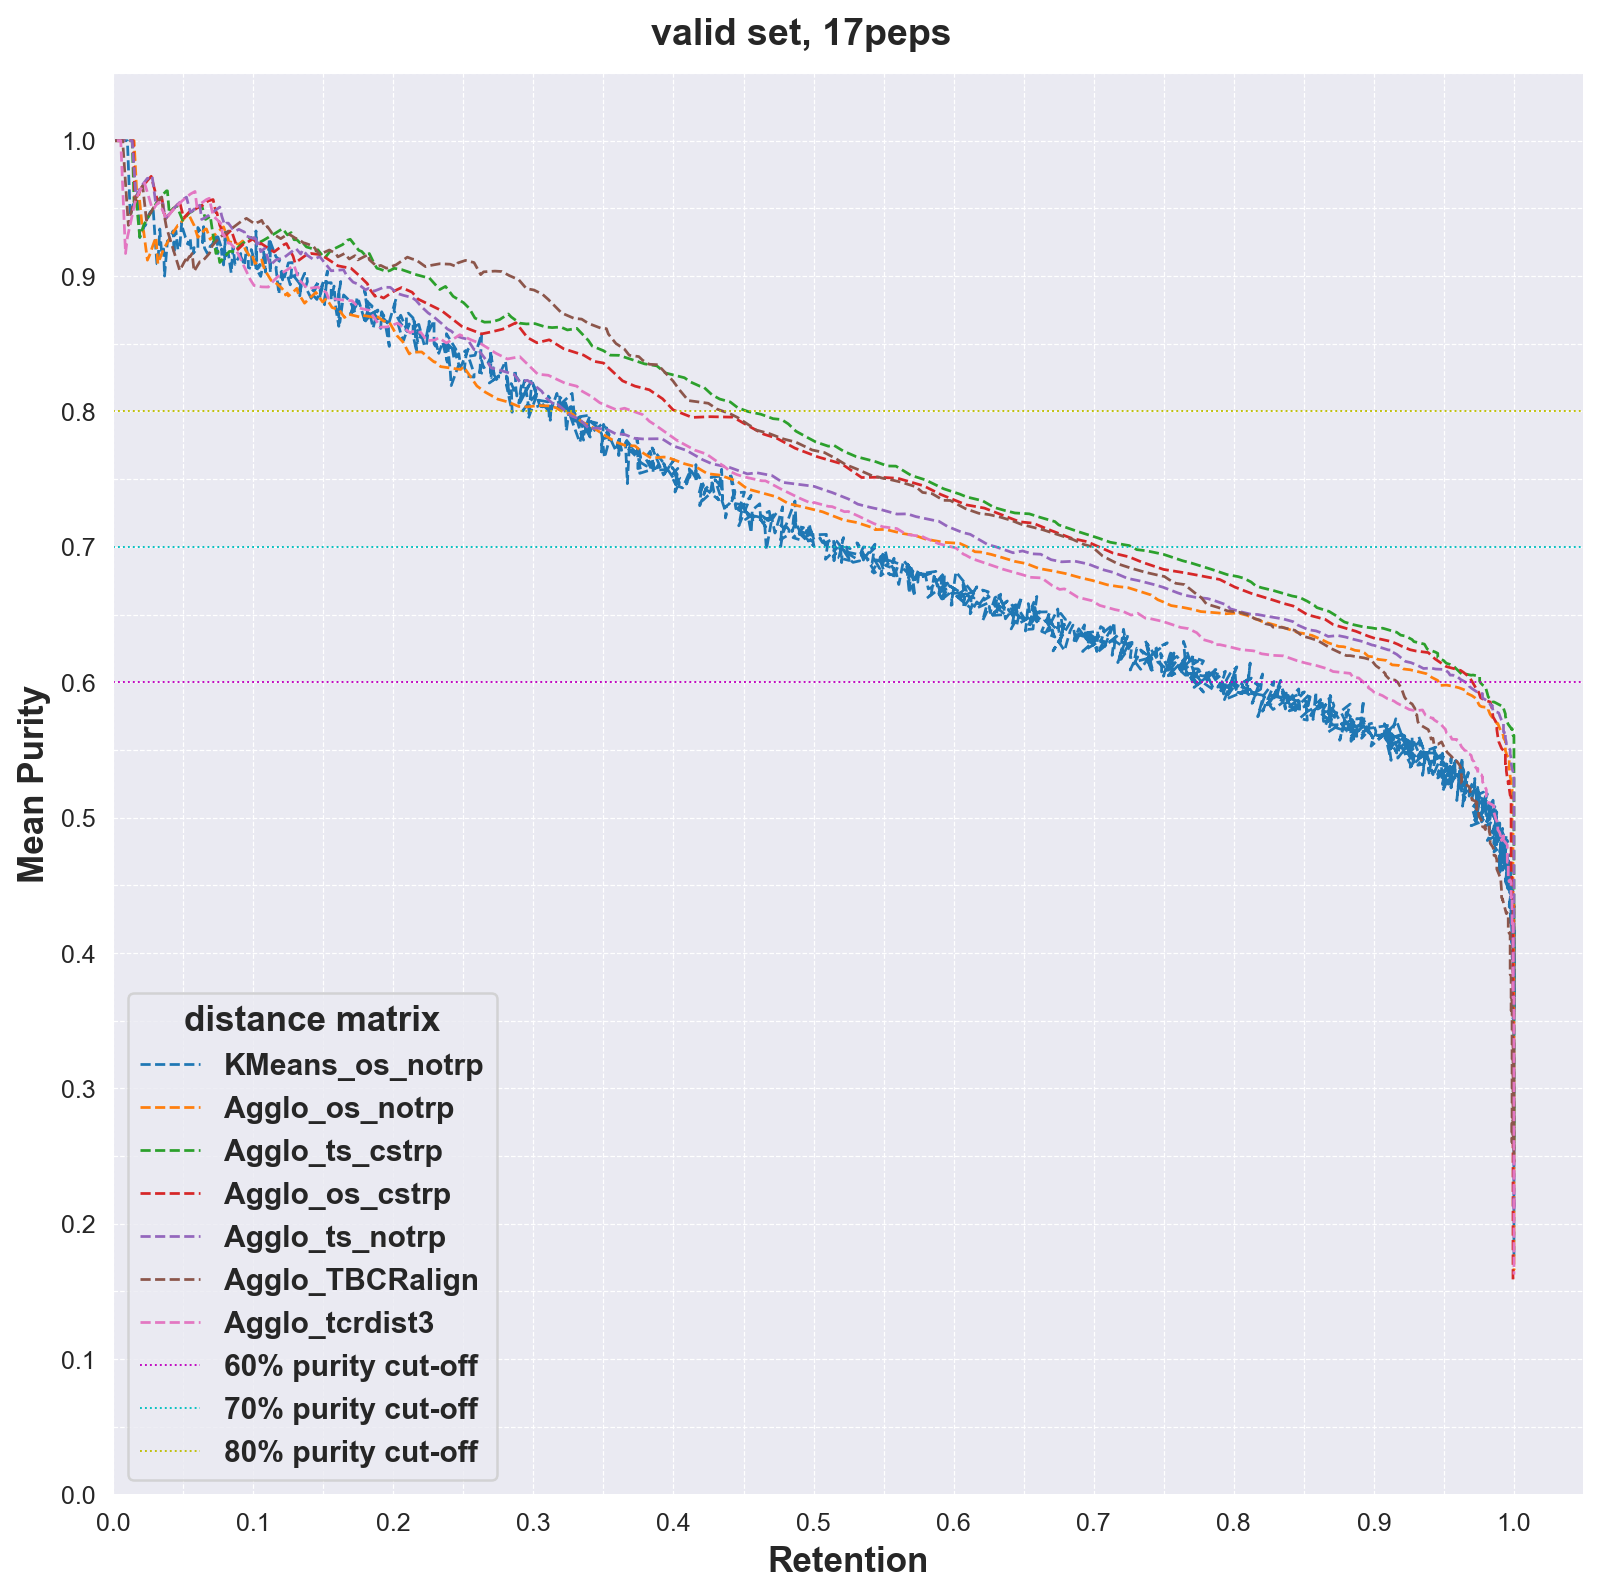

In [24]:
plot_retention_purities(concat_res.query('partition=="valid"').drop(columns=['input_type']).rename(columns={'hue':'input_type'}), title='valid set, 17peps')

(<Figure size 1620x1620 with 1 Axes>,
 <Axes: xlabel='Retention', ylabel='Mean Purity'>)

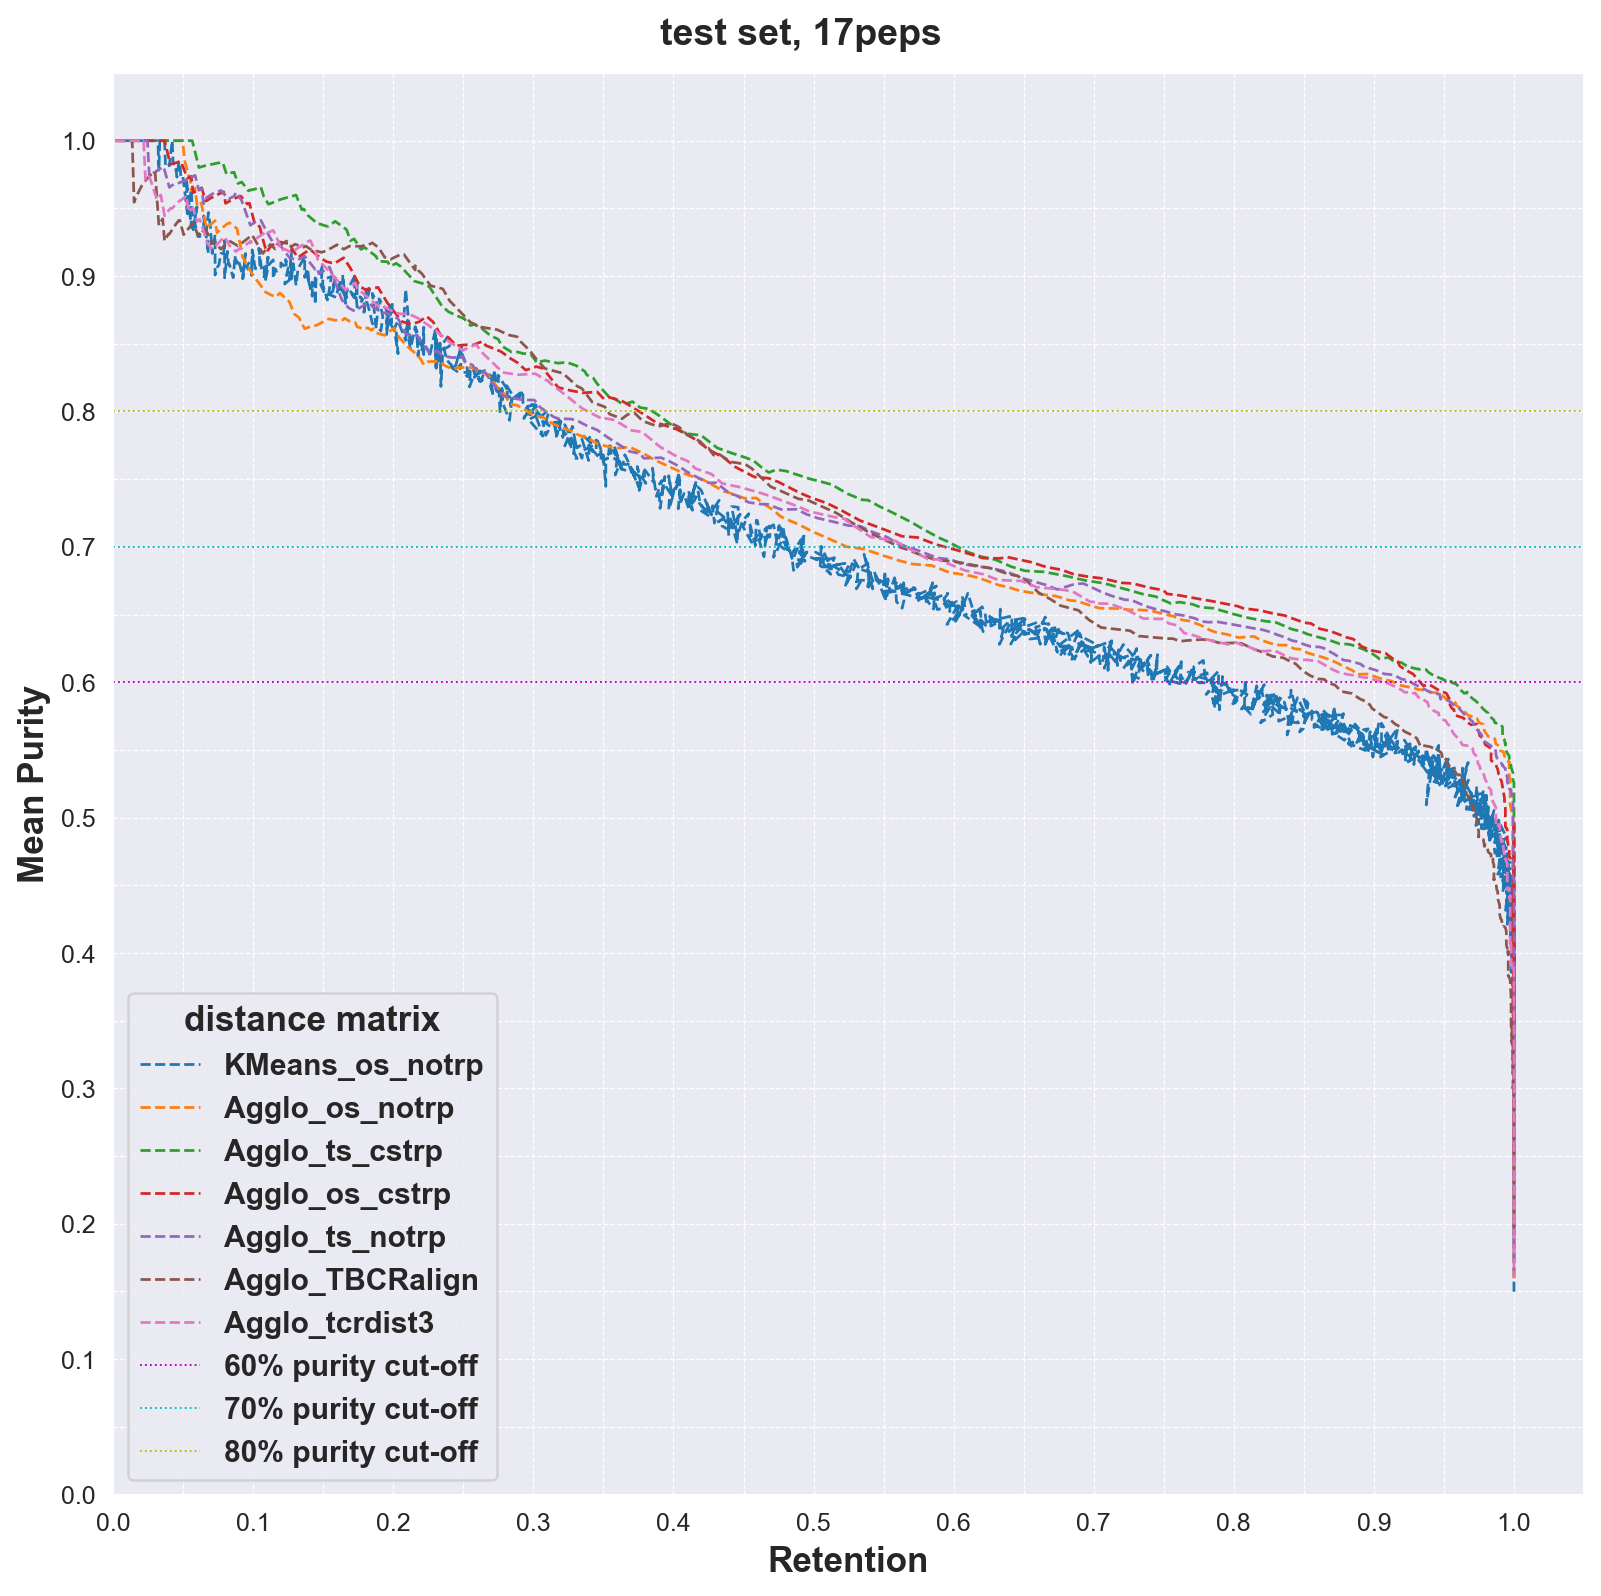

In [23]:
plot_retention_purities(concat_res.query('partition=="test"').drop(columns=['input_type']).rename(columns={'hue':'input_type'}), title='test set, 17peps')

In [30]:
concat_res.query('partition=="valid" and clustering=="Agglo" and input_type=="os_cstrp"').loc[concat_res.query('partition=="valid" and clustering=="Agglo" and input_type=="os_cstrp"')['silhouette'].idxmax()]

threshold                    0.38982
n_cluster                          1
n_singletons                       1
n_cluster_over_70p                 0
mean_purity                 0.157823
min_purity                  0.157823
max_purity                  0.157823
mean_cluster_size             1470.0
min_cluster_size              1470.0
max_cluster_size              1470.0
silhouette                  0.464159
ch_index                    2.027156
db_index                     0.69831
ARI                        -0.000215
retention                    0.99932
input_type                  os_cstrp
dataset                          NaN
partition                      valid
clustering                     Agglo
db                             top17
hue                   Agglo_os_cstrp
Name: 9323, dtype: object

# Cancer QVD vs KSA

## inits

In [98]:
import csv
def get_metadata(filename):
    # Initialize a dictionary to hold the header information
    metadatares = {'filename':os.path.basename(filename)}
    metadatares['relpath']=filename
    # Read the CSV file
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        # Read the first line which contains the metadata
        metadata_line = next(reader)[0]
        # Convert the metadata line to a dictionary
        metadata = eval(metadata_line)
    metadatares.update(metadata)
    return metadatares
    
def read_ots_data(filename):
    metadata = get_metadata(filename)
    df = pd.read_csv(filename, skiprows=1)
    df = df[[c for c in df.columns if ('aa' in c.lower() and 'cdr' in c.lower()) or 'call' in c.lower()]]
    df.columns = [x.replace('cdr','').replace('_aa_','').replace('beta','B').replace('alpha','A')[::-1] if 'cdr' in x else x for x in df.columns]
    df.columns = df.columns.str.replace('_call','')
    df['Link']=metadata['Link']
    df['Disease']=metadata['Disease']
    df['CancerType']=metadata['CancerType']
    df['Source']=metadata['TSource']
    df['Subject']=metadata['Subject']
    return df, metadata

def read_ots_unique(filename):
    df, metadata = read_ots_data(filename)
    df['tcr'] = df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
    metadata['n_seq'] = len(df)
    metadata['unique'] = len(df.tcr.unique())
    counts = df.groupby('tcr').agg(count=('B3','count'))
    df = df.drop_duplicates(subset=['tcr'])
    df = df.set_index('tcr').merge(counts,left_index=True,right_index=True).reset_index()
    df['Run']=metadata['Run']
    df['TSubtype'] = metadata['TSubtype']
    return df, metadata
    
def read_subtype(df, source, subtype):
    paths = df.query('TSource.str.contains(@source) and TSubtype.str.contains(@subtype)')['relpath'].values
    return pd.concat([read_ots_unique(x)[0] for x in paths]).drop_duplicates('tcr')

In [59]:
ebh = pd.read_csv('../data/OTS/metadata/cancer_eberhardt.csv')
ksa_paths = ebh.query('TSubtype.str.contains("ksa")')['relpath'].unique()
qvd_paths = ebh.query('TSubtype.str.contains("qvd")')['relpath'].unique()

In [99]:
# Two HPV-specific peptides tetramers : QVDYYGLYY (A0101), KSAIVTLTY (A01-01)
# and PD-1+ for the immune blockade pathway 
tmp = ebh.query('Author.str.contains("Eber") and TSubtype.str.contains("tetramer") and Subject in ["hpv15","hpv34", "hpv51", "hpv7"]')
tmp.groupby(['Subject','TSource', 'TSubtype', 'Treatment', 'CancerType']).agg(count=('n_seq','count'),
                                                                              avg_unique = ('n_unique', 'mean'),
                                                                              max_unique = ('n_unique', 'max'),
                                                                              min_unique = ('n_unique', 'min'))

count  \
Subject TSource               TSubtype     Treatment CancerType          
hpv15   tumor                 tetramer_ksa untreated hpv+_hnscc      1   
                              tetramer_qvd untreated hpv+_hnscc      1   
hpv34   metastatic_lymph_node tetramer_ksa untreated hpv+_hnscc      3   
                              tetramer_qvd untreated hpv+_hnscc      3   
        tumor                 tetramer_qvd untreated hpv+_hnscc      3   
hpv51   metastatic_lymph_node tetramer_qvd untreated hpv+_hnscc      3   
        tumor                 tetramer_ksa untreated hpv+_hnscc      3   
                              tetramer_qvd untreated hpv+_hnscc      3   
hpv7    metastatic_lymph_node tetramer_ksa untreated hpv+_hnscc      3   
                              tetramer_qvd untreated hpv+_hnscc      3   
        tumor                 tetramer_ksa untreated hpv+_hnscc      3   

                                                                 avg_unique  \
Subject TSource               TSubtype     Treatment CancerType               
hpv15   tumor                 tetramer_ksa untreated hpv+_hnscc   14.000000   
                              tetramer_qvd untreated hpv+_hnscc   15.000000   
hpv34   metastatic_lymph_node tetramer_ksa untreated hpv+_hnscc   13.666667   
                              tetramer_qvd untreated hpv+_hnscc   34.666667   
        tumor                 tetramer_qvd untreated hpv+_hnscc   26.000000   
hpv51   metastatic_lymph_node tetramer_qvd untreated hpv+_hnscc    5.000000   
        tumor                 tetramer_ksa untreated hpv+_hnscc    3.666667   
                              tetramer_qvd untreated hpv+_hnscc    6.666667   
hpv7    metastatic_lymph_node tetramer_ksa untreated hpv+_hnscc   19.000000   
                              tetramer_qvd untreated hpv+_hnscc   56.000000   
        tumor                 tetramer_ksa untreated hpv+_hnscc   17.333333   

                                                                 max_unique  \
Subject TSource               TSubtype     Treatment CancerType               
hpv15   tumor                 tetramer_ksa untreated hpv+_hnscc          14   
                              tetramer_qvd untreated hpv+_hnscc          15   
hpv34   metastatic_lymph_node tetramer_ksa untreated hpv+_hnscc          16   
                              tetramer_qvd untreated hpv+_hnscc          35   
        tumor                 tetramer_qvd untreated hpv+_hnscc          27   
hpv51   metastatic_lymph_node tetramer_qvd untreated hpv+_hnscc           5   
        tumor                 tetramer_ksa untreated hpv+_hnscc           5   
                              tetramer_qvd untreated hpv+_hnscc           7   
hpv7    metastatic_lymph_node tetramer_ksa untreated hpv+_hnscc          21   
                              tetramer_qvd untreated hpv+_hnscc          57   
        tumor                 tetramer_ksa untreated hpv+_hnscc          18   

                                                                 min_unique  
Subject TSource               TSubtype     Treatment CancerType              
hpv15   tumor                 tetramer_ksa untreated hpv+_hnscc          14  
                              tetramer_qvd untreated hpv+_hnscc          15  
hpv34   metastatic_lymph_node tetramer_ksa untreated hpv+_hnscc          12  
                              tetramer_qvd untreated hpv+_hnscc          34  
        tumor                 tetramer_qvd untreated hpv+_hnscc          25  
hpv51   metastatic_lymph_node tetramer_qvd untreated hpv+_hnscc           5  
        tumor                 tetramer_ksa untreated hpv+_hnscc           3  
                              tetramer_qvd untreated hpv+_hnscc           6  
hpv7    metastatic_lymph_node tetramer_ksa untreated hpv+_hnscc          17  
                              tetramer_qvd untreated hpv+_hnscc          55  
        tumor                 tetramer_ksa untreated hpv+_hnscc          17

In [122]:
hpv15 = ebh.query('Subject=="hpv15"')
hpv34 = ebh.query('Subject=="hpv34"')
hpv51 = ebh.query('Subject=="hpv51"')
hpv7 = ebh.query('Subject=="hpv7"')
hpv34_ksa = read_subtype(hpv34, "lymph", "ksa")
hpv34_qvd = read_subtype(hpv34, "lymph", "qvd")
hpv15_ksa = read_subtype(hpv15, "tumor", "ksa")
hpv15_qvd = read_subtype(hpv15, "tumor", "qvd")
hpv51_ksa = read_subtype(hpv51, "tumor", "ksa")
hpv51_qvd = read_subtype(hpv51, "tumor", "qvd")
hpv7_ksa = read_subtype(hpv7, "lymph", "ksa")
hpv7_qvd = read_subtype(hpv7, "lymph", "qvd")

hpv34 = pd.concat([hpv34_ksa.assign(index_col=[f'hpv34_ksa_{i:03}' for i in range(len(hpv34_ksa))]),
                   hpv34_qvd.assign(index_col=[f'hpv34_qvd_{i:03}' for i in range(len(hpv34_qvd))])]).drop_duplicates('tcr')
hpv15 = pd.concat([hpv15_ksa.assign(index_col=[f'hpv15_ksa_{i:03}' for i in range(len(hpv15_ksa))]),
                   hpv15_qvd.assign(index_col=[f'hpv15_qvd_{i:03}' for i in range(len(hpv15_qvd))])]).drop_duplicates('tcr')
hpv51 = pd.concat([hpv51_ksa.assign(index_col=[f'hpv51_ksa_{i:03}' for i in range(len(hpv51_ksa))]),
                   hpv51_qvd.assign(index_col=[f'hpv51_qvd_{i:03}' for i in range(len(hpv51_qvd))])]).drop_duplicates('tcr')
hpv7 = pd.concat([hpv7_ksa.assign(index_col=[f'hpv7_ksa_{i:03}' for i in range(len(hpv7_ksa))]),
                  hpv7_qvd.assign(index_col=[f'hpv7_qvd_{i:03}' for i in range(len(hpv7_qvd))])]).drop_duplicates('tcr')

In [124]:
%mkdir ../data/OTS/eberhardt_cancer
hpv34.to_csv('../data/OTS/eberhardt_cancer/hpv34_mixed_qvd_ksa.txt', index=False)
hpv15.to_csv('../data/OTS/eberhardt_cancer/hpv15_mixed_qvd_ksa.txt', index=False)
hpv51.to_csv('../data/OTS/eberhardt_cancer/hpv51_mixed_qvd_ksa.txt', index=False)
hpv7.to_csv('../data/OTS/eberhardt_cancer/hpv7_mixed_qvd_ksa.txt', index=False)

mkdir: ../data/OTS/eberhardt_cancer: File exists


In [134]:
%rm -r ../data/OTS/eberhardt_garner_mixed_subsampled/

In [148]:
%mkdir ../data/OTS/eberhardt_garner_mixed_subsampled/
tcrs = pd.concat([hpv7, hpv15, hpv34, hpv51]).tcr.unique()
g = garner.query('count==1 and tcr not in @tcrs')
g['TSubtype'] = 'healthy'
for seed in range(100):
    pd.concat([hpv7, g.sample(n=len(hpv7), random_state=seed)]).reset_index(drop=True).to_csv(f'../data/OTS/eberhardt_garner_mixed_subsampled/hpv7_garner_subsampled_seed_{seed:03}.txt')
    pd.concat([hpv15, g.sample(n=len(hpv15), random_state=seed)]).reset_index(drop=True).to_csv(f'../data/OTS/eberhardt_garner_mixed_subsampled/hpv15_garner_subsampled_seed_{seed:03}.txt')
    pd.concat([hpv34, g.sample(n=len(hpv34), random_state=seed)]).reset_index(drop=True).to_csv(f'../data/OTS/eberhardt_garner_mixed_subsampled/hpv34_garner_subsampled_seed_{seed:03}.txt')
    pd.concat([hpv51, g.sample(n=len(hpv51), random_state=seed)]).reset_index(drop=True).to_csv(f'../data/OTS/eberhardt_garner_mixed_subsampled/hpv51_garner_subsampled_seed_{seed:03}.txt')

mkdir: ../data/OTS/eberhardt_garner_mixed_subsampled/: File exists


## results 

# ?